# Test the fine tuned model

In [81]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read
from ase.data import chemical_symbols
from ase.atoms import Atoms
import copy
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy.stats import spearmanr, kendalltau

import matplotlib.pyplot as plt

import sys
import os
import json
import re
import shutil as sh

from janus_core.calculations.single_point import SinglePoint
from janus_core.calculations.geom_opt import GeomOpt

current_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(current_dir)

from structure_generation import get_all_configurations_pmg, write_extended_xyz, generate_random_structures, \
    write_CRYSTAL_gui_from_data

from local_functions import lattice_params_to_matrix, get_errors, get_rankings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Single point example

In [13]:
ase_structure = read('data/crystal/test_files/test_concatenated.xyz', index=":")
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/1000/AlGaN-medium-mpa-0.model",
    calc_kwargs={"default_dtype": "float64"},
    properties="energy",
)

init_energy = sp_mace.run()["energy"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
[-482438.0979418563, -482438.20363944303]


In [32]:
ase_structure = Atoms('N',[[0.0, 0.0, 0.0]])
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/1000/AlGaN-medium-mpa-0.model",
    calc_kwargs={"default_dtype": "float64"},
    properties="energy",
)

init_energy = sp_mace.run()["energy"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
-1483.705316803


### Geometry optimisation example

In [ ]:
ase_structure = read('data/crystal/AlGaN/super3/extxyz_files/AlGaN_super3_1_0_0.xyz')
optimized_structure = GeomOpt(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/fine_tuned/1000/AlGaN-medium-mpa-0.model",
    calc_kwargs={"default_dtype": "float64"},
    fmax=0.001,
    filter_kwargs={"hydrostatic_strain": True},
)
optimized_structure.run()

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
       Step     Time          Energy          fmax
LBFGS:    0 17:57:50  -482438.097942        0.367193
LBFGS:    1 17:57:52  -482438.104185        0.365492
LBFGS:    2 17:57:54  -482438.320745        0.300169
LBFGS:    3 17:57:56  -482438.494879        0.234136
LBFGS:    4 17:57:58  -482438.625663        0.167811
LBFGS:    5 17:58:00  -482438.712262        0.101658
LBFGS:    6 17:58:02  -482438.754157        0.036178


TypeError: len() of unsized object

### Compare energies DFT/MACE 

### mace-mpa-0-medium.model

## I need to 

1000

In [37]:
al_dft_energy = -6.589117430582E+03
ga_dft_energy = -5.236806134899E+04
n_dft_energy = -1.483705316803E+03

al_mace_energy = -6589.117430582
ga_mace_energy = -52368.06134899
n_mace_energy = -1483.705316803

num_sites = 54 # there are 54 anion and 54 cation sites

In [43]:
energies = np.loadtxt("data/fine_tuning/1000/energies.csv", delimiter=",", skiprows=1)

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column
num_al = energies[:, 2]

dft_energies_form = (dft_energies - (al_dft_energy*num_al + 
                                    ga_dft_energy*(num_sites-num_al) + n_dft_energy*num_sites))/num_sites

mace_energies_form = (mace_energies - (al_mace_energy*num_al + 
                                    ga_mace_energy*(num_sites-num_al) + n_mace_energy*num_sites))/num_sites

### Errors

In [82]:
get_errors(dft_energies_form,mace_energies_form)

MSE: 0.0004253196296340794
RMSE: 0.020623278828403584
Percentage MSE: 0.00029537918093394124 %
Max Absolute Error: 0.0926661571375682
Max Percentage Error: 0.7752914325951553 %


### Ranking

These are calculated over the whole range, so it doesn't capture the fine details of the ranking within a fixed composition.

In [83]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.9996744918622967
Kendall's Tau: 0.989145728643216


### Parity plot

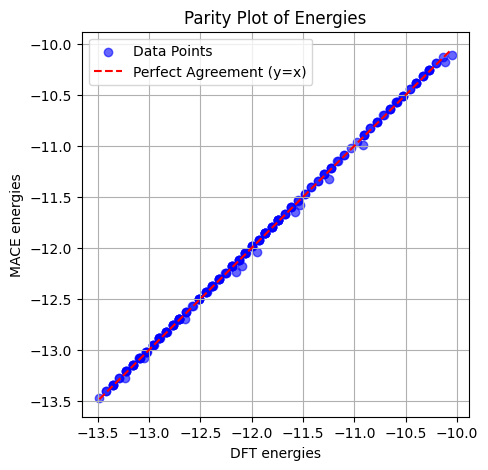

In [46]:
# Create the parity plot
plt.figure(figsize=(5,5))
plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Agreement (y=x)")

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Simulated annealing